<a href="https://colab.research.google.com/github/anna-dang/mod05-capstone/blob/main/NLP_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hotel Review Classifier (working title)

*Flatiron School Data Science Bootcamp*

Captsone Project - NLP Sentiment/Ratings Analysis

Anna D'Angela | [annaadangela@gmail.com](mailto:annaadangela@gmail.com)

[Return to GitHub repo](https://github.com/anna-dang/mod05-capstone) 


# EDA TODO
- upgrade plot design
- organize libraries
- check for non-english?

In [56]:
# Standard libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Mapping libraries
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

# NLP libraries
import nltk
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')

# Modeling libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import set_config
from sklearn.model_selection import GridSearchCV

# My custome functions
from capstone_functions import NLP_functions as NLP

# Random seed
seed = 619

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/annadangela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annadangela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import data and explore

In [4]:
# Import clean data
df_raw = pd.read_csv("./data/clean_scrape.csv")

# Check load
display(df_raw.head())
df_raw.info()

,Location,Hotel,Title,Review,Rating
0,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Great View,Easy check in and check out process using the ...,5
1,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Clean and Comfortable,We needed a last-minute place to stay in Denve...,5
2,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Excellent Staff & Service,We love Hyatt hotels and have had many great e...,5
3,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Trip to Denver - a Hallmark Christmas,"I have never encountered such helpful, friendl...",5
4,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Our 'see downtown' hotel,"We love it here! Great service, they usually r...",5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22217 entries, 0 to 22216
Data columns (total 5 columns):
Location    22217 non-null object
Hotel       22217 non-null object
Title       22217 non-null object
Review      22217 non-null object
Rating      22217 non-null int64
dtypes: int64(1), object(4)
memory usage: 868.0+ KB


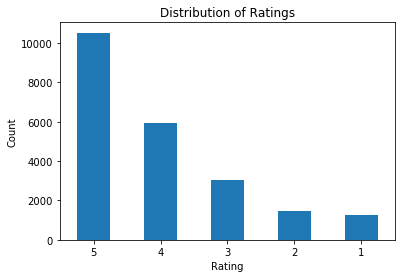

In [5]:
# Examine class distribution by count
df_raw['Rating'].value_counts().plot(kind='bar', rot = 0);
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel("Count")
plt.show()

In [6]:
# Examine imbalance as percentage
percent = round(df_raw['Rating'].value_counts(1).to_frame(name='Percent %').rename_axis('Rating') * 100, 2)
percent

,Percent %
Rating,
5,47.36
4,26.66
3,13.62
2,6.69
1,5.67


There is a significant imbalance in classes. First I will randomly undersample the most major class, 5 by equalizing the amount with the second highest class, 4. This is to reduce the dimensions for the model by growing the total corpus largely positive.

In [7]:
tot_5 = df_raw[df_raw['Rating'] == 5].count()[0] 
tot_4 = df_raw[df_raw['Rating'] == 4].count()[0] 
drop_n = tot_5 - tot_4
drop_n

4600

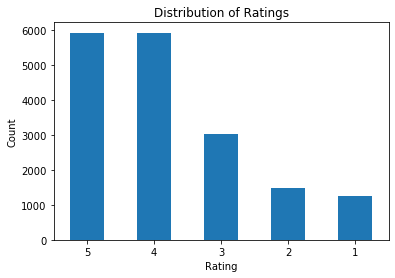

In [8]:
test = df_raw.drop(df_raw[df_raw['Rating'].eq(5)].sample(drop_n, random_state=seed).index)

# Examine class distribution by randomly reducing the most major class
test['Rating'].value_counts().plot(kind='bar', rot = 0);
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel("Count")
plt.show()

Remaining class imbalance is less sever, I will address this by using class weights when modeling.

### Collection distribution

In [20]:
# Examine collection distribution by location
avg_df = df_raw.groupby(by = 'Hotel')[['Rating']].agg(['count', 'mean'])

coords = pd.read_csv("./data/coordinates.csv", names = ['Hotel', 'Lat', 'Long'])

map_df = pd.merge(avg_df, coords, on = 'Hotel')
map_df.columns = ['Hotel', 'Rating_count', 'Rating_mean', 'Lat', 'Long']
map_df

,Hotel,Rating_count,Rating_mean,Lat,Long
0,Baymont by Wyndham Denver International Airport,2094,3.949379,39.820740,-104.770119
1,Best Western Plus Denver International Airport...,1000,3.633000,39.824161,-104.770178
2,Clarion Hotel Denver Central,920,3.372826,39.783300,-104.990895
3,DoubleTree by Hilton Hotel Denver,2000,3.859500,39.763101,-104.904370
4,Embassy Suites by Hilton Denver International ...,1000,3.996000,39.824143,-104.775354
5,Grand Hyatt Denver Downtown,1000,4.488000,39.745762,-104.988802
6,Hilton Denver City Center,1000,4.101000,39.747159,-104.990145
7,Hyatt Place Denver/Cherry Creek,995,4.156784,39.695828,-104.938547
8,Hyatt Regency Denver At Colorado Convention Ce...,2000,4.460000,39.744213,-104.993667
9,La Quinta Inn & Suites by Wyndham Denver Airpo...,1000,3.803000,39.820897,-104.773078


In [33]:
# View hotels on map
px.set_mapbox_access_token(open("./driver/mapbox_token").read())

fig = px.scatter_mapbox(map_df,
                        title="Data Source Map - Denver Metro Area Hotels",
                        hover_name='Hotel',
                        lat='Lat',
                        lon='Long',
                        color='Rating_mean',
                        color_continuous_scale=px.colors.sequential.Tealgrn,
                        size='Rating_count',
                        size_max=15,
                        zoom=10,
                        height=500
                       )
fig.update_layout(title_font_family="Arial, bold",
                    title_font_color="black",
                    mapbox={"style": "stamen-toner"},
                    margin={"l": 0, "r": 0, "b": 0, "t": 80}
                    )
    
fig.show()

### Pre-processing

In [34]:
# combine 'Title' and 'Review' into one chunk of text (seperate with a space)
df_raw['Review'] = df_raw['Title'] + ' ' + df_raw['Review']
df_raw.head()

,Location,Hotel,Title,Review,Rating
0,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Great View,Great View Easy check in and check out process...,5
1,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Clean and Comfortable,Clean and Comfortable We needed a last-minute ...,5
2,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Excellent Staff & Service,Excellent Staff & Service We love Hyatt hotels...,5
3,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Trip to Denver - a Hallmark Christmas,Trip to Denver - a Hallmark Christmas I have n...,5
4,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Our 'see downtown' hotel,Our 'see downtown' hotel We love it here! Grea...,5


In [35]:
# Drop columns uneeded for this analysis, save as working df for modeling
df = df_raw.drop(columns = ['Location', 'Hotel', 'Title'])
df.head()

,Review,Rating
0,Great View Easy check in and check out process...,5
1,Clean and Comfortable We needed a last-minute ...,5
2,Excellent Staff & Service We love Hyatt hotels...,5
3,Trip to Denver - a Hallmark Christmas I have n...,5
4,Our 'see downtown' hotel We love it here! Grea...,5


### Train / Test Split

**Split the sample data into 2 groups**: train and test, where train is further split into train and validation set k times using k-fold cross validation, and test is used to assess final model fitness.

# TODO
- working with 'test' df, manually equalized class 4 and 5; try with full data?

In [38]:
# Split BEFORE processsing to avoid leaking
X = test['Review']
y = test['Rating']

X_train, X_test, y_train, y_test =train_test_split(X, y, random_state=seed)

X_train.shape, X_test.shape

((13212,), (4405,))

In [39]:
# Class imbalance
y_train.value_counts(1) * 100

4    33.923706
5    33.303058
3    16.969422
2     8.636088
1     7.167726
Name: Rating, dtype: float64

### NLP Preprocessing / Corpus EDA
Transform unstructured data to a matrix of numbers. Fits to entire training data 'X_train' to build entire corpus.

#### Feature Engineering for Text Data
- Do we remove stop words or not?
- Do we stem or lemmatize our text data, or leave the words as is?
- Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
- Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
- Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
- What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

Start at baseline model, then adjust and see results.

# NLP TODO

- visuals: word cloud per class, freq dist plot

- process function

- tokenizer pipeline????

- custom stop words/punct

- DROP common words: hotel, room, Denver..... non-signally common occuring to give model most meaningful pool



#### Tokenize / Dimensionality Reduction

TODO cleaning - remove punctuation, captialization, regex for conjunctions

In [42]:
# TODO regex tokenize: count words with apostrophes as a single word
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

In [51]:
# tokenize, remove capitals
corpus = ','.join(df['Review'])

tokens = word_tokenize(corpus.lower())

len(tokens)

2554890

In [46]:
# remove stops words, reduce dimensionality
stopword_list = stopwords.words('english')
stopword_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [50]:
# punctuation
stopword_list.extend(string.punctuation)
stopword_list += ["''", '""', '...', '``']
stopword_list[-10:]

['_', '`', '{', '|', '}', '~', "''", '""', '...', '``']

In [63]:
len(stopword_list)

247

In [ ]:
# TODO remove numbers?

In [ ]:
# remove non-english words/char

In [ ]:
# EXPLORE THIS, likely not necessary 
# stem or lemm to reduce words to base

# lemmatizer = WordNetLemmatizer()

# print(lemmatizer.lemmatize('feet')) # foot

In [52]:
# remove
stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopword_list]
len(stopped_tokens)

1199404

In [53]:
# dropped stops and puncts
len(tokens) - len(stopped_tokens)

1355486

#### Frequency Distribution

In [55]:
# visual: freqeuncy distribution
freq = nltk.FreqDist(stopped_tokens)
freq.most_common(20)

# TODO PLOT total

[('hotel', 29954),
 ('room', 22180),
 ('great', 15302),
 ('stay', 14232),
 ('staff', 12406),
 ('denver', 9731),
 ('nice', 9425),
 ('good', 8927),
 ('clean', 8541),
 ('would', 8219),
 ("n't", 8178),
 ('rooms', 7844),
 ('location', 7808),
 ('service', 7505),
 ('airport', 6986),
 ('breakfast', 6974),
 ('one', 6532),
 ('stayed', 5829),
 ('night', 5599),
 ('friendly', 5591)]

In [ ]:
# loop to plot per class

In [ ]:
# any to remove??? (appearing in all classes, thus not strong signal)
# removed_words = stop words list + common words list

#### Word Cloud per class

In [ ]:
# word clouds per class here:
# these words are probably the least important, as they are most likely words that are used across multiple classes

In [95]:
def plot_cloud(df, rating=int, pattern=None, stopwords=None):
    
    reviews = df.loc[df['Rating'] == rating]['Review']
    
    text = " ".join(review for review in reviews)
    
    wordcloud = WordCloud(random_state=seed, colormap='plasma', 
                          collocations=False, regexp=pattern, 
                          background_color="white",
                          stopwords=stopwords).generate(text)
    
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off");

In [ ]:
# loop to plot clouds....... 

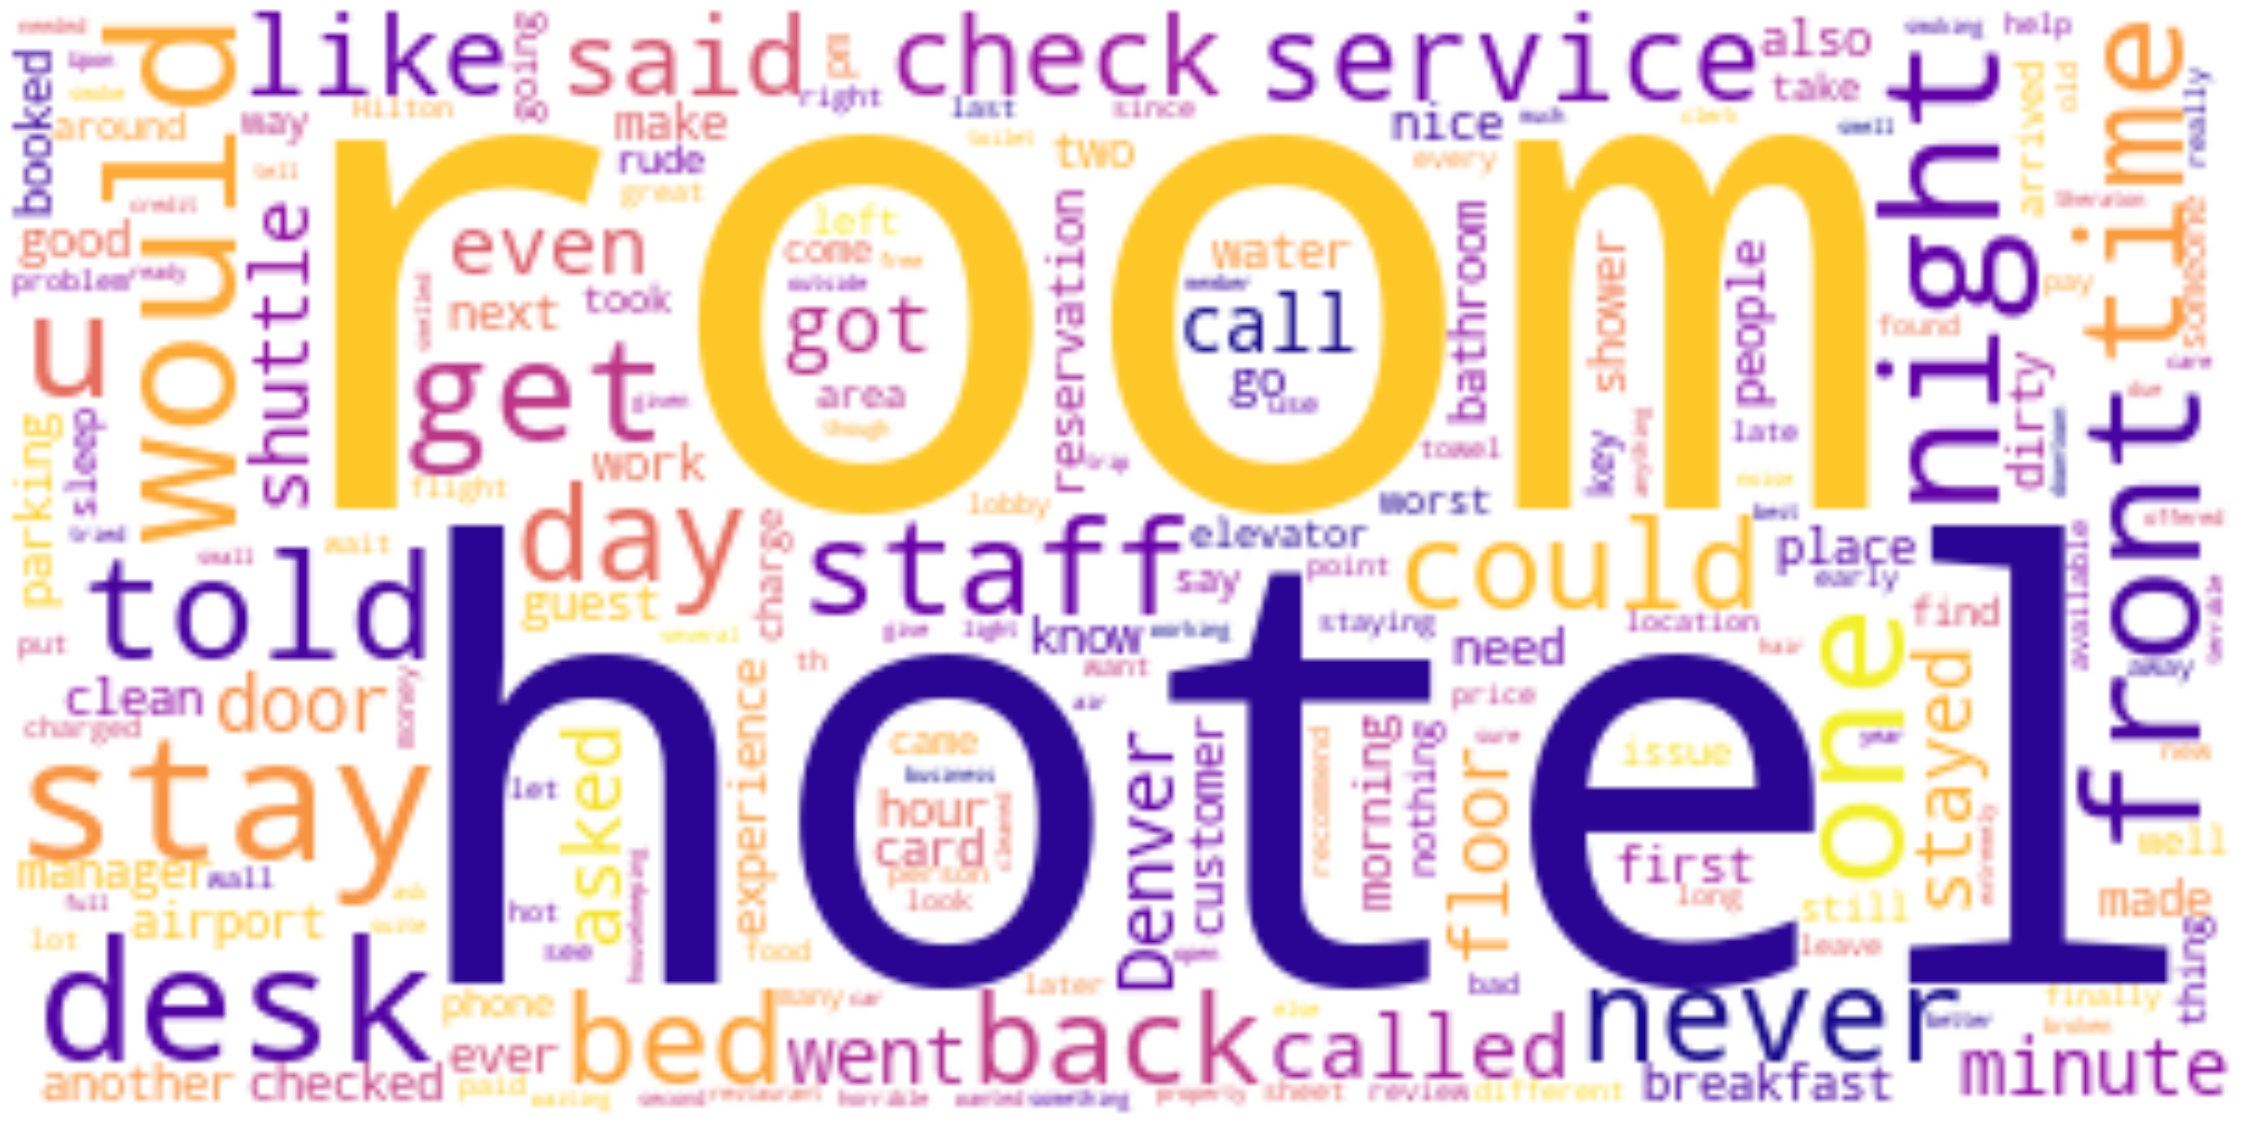

In [73]:
plot_cloud(test, rating=1, pattern=pattern, stopwords=stopword_list)

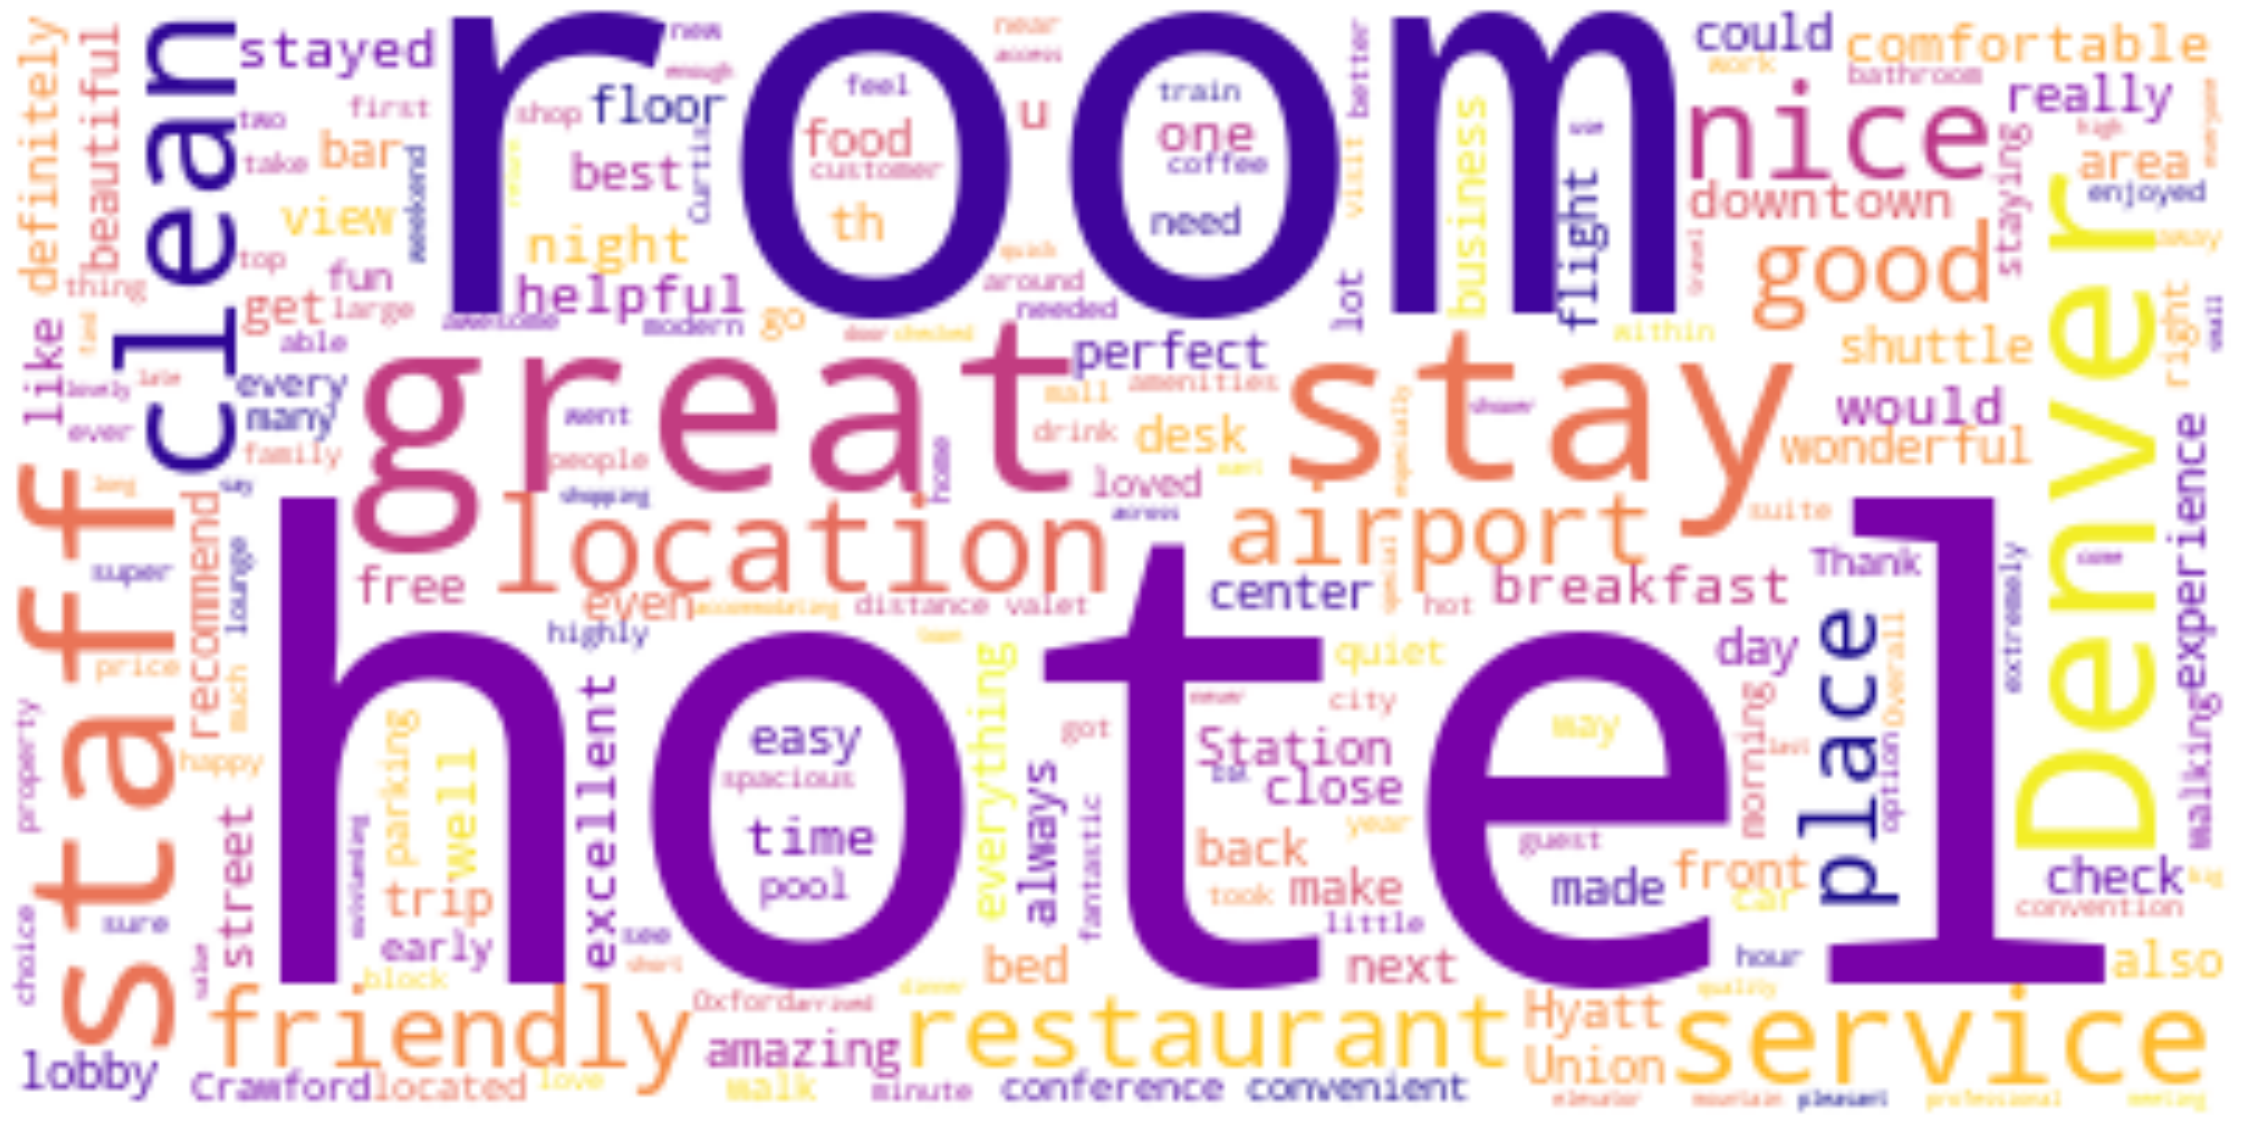

In [75]:
plot_cloud(df, rating=5, pattern=pattern, stopwords=stopword_list)

In [ ]:
# TODO: pull out hotel vocab, location details, titles/names? make more generic?
# distilling the overall vocabulary of our bag-of-words down only to the words that really matter

#### Vocabulary EDA

In [76]:
# N-grams, filter occruing greater than 5 times (frequency filter) keep only those that likely 'mean' something

# shorter alias for bigram method
bigram_measures = nltk.collocations.BigramAssocMeasures()

# create a finder
finder = nltk.collocations.BigramCollocationFinder.from_words(stopped_tokens)

# bigram scores
scored = finder.score_ngrams(bigram_measures.raw_freq)
scored[:50]

[(('front', 'desk'), 0.0034183644543456584),
 (('great', 'location'), 0.0017250234283027236),
 (('staff', 'friendly'), 0.0013648445394545958),
 (('downtown', 'denver'), 0.001253122384117445),
 (('room', 'clean'), 0.0011780851156074183),
 (('16th', 'street'), 0.0011547401876265211),
 (('union', 'station'), 0.0011464027133476294),
 (('walking', 'distance'), 0.0010655292128423784),
 (('place', 'stay'), 0.0010046656506064679),
 (('hotel', 'great'), 0.0009154546758223251),
 (('great', 'hotel'), 0.0008887747581298712),
 (('customer', 'service'), 0.0008604273455816389),
 (('one', 'night'), 0.0008504223764469686),
 (('convention', 'center'), 0.0008254099536102931),
 (('nice', 'hotel'), 0.0008087350050525094),
 (('friendly', 'helpful'), 0.0008054000153409526),
 (('street', 'mall'), 0.0007895588142110582),
 (('would', 'stay'), 0.0007878913193552798),
 (('hotel', 'staff'), 0.0007495389376723772),
 (('clean', 'comfortable'), 0.0007487051902444881),
 (('room', 'service'), 0.0007228590199799234),
 (

In [77]:
# Pointwise Mutual Information (pmi) Score - muual dependence between words

# create finder from corpus
pmi_finder = nltk.collocations.BigramCollocationFinder.from_words(stopped_tokens)

# apply frequency filter and set n
pmi_finder.apply_freq_filter(5)

# use finder to calculate PMI scores
pmi_scored = pmi_finder.score_ngrams(bigram_measures.pmi)
pmi_scored[:50]

[(('barnes', 'noble'), 17.608923757900495),
 (('darth', 'vader'), 17.60892375790049),
 (('ellie', 'caulkins'), 17.60892375790049),
 (('johnson', 'wales'), 17.60892375790049),
 (('los', 'angeles'), 17.386531336564047),
 (('marco', 'polo'), 16.971493837285202),
 (('crabtree', 'evelyn'), 16.871958163734288),
 (('bubba', 'gumps'), 16.734454639984353),
 (('corn', 'flakes'), 16.734454639984353),
 (('bubba', 'gump'), 16.73445463998435),
 (('c.o', 'bigelow'), 16.608923757900495),
 (('marge', 'simpson'), 16.27105411914411),
 (('clorox', 'wipes'), 16.19388625862165),
 (('katie', 'mullens'), 16.164138915227596),
 (('refried', 'beans'), 16.164138915227596),
 (('washers', 'dryers'), 16.12349693073025),
 (('caulkins', 'opera'), 16.023961257179337),
 (('smack', 'dab'), 16.023961257179337),
 (('i.m', 'pei'), 15.9995082134548),
 (('mt', 'evans'), 15.930851852787855),
 (('captive', 'audience'), 15.908484039759403),
 (('duct', 'tape'), 15.80156883584289),
 (('gon', 'na'), 15.801568835842886),
 (('bent', 

In [79]:
### TF-IDF - which words appear heavily in one class vs others
# Make a TfIdf Vectorizer
# focus on words that appear heavily in articles from a given class, but rarely appear in articles from other classes. 
# You may recall from previous lessons that this is exactly where TF-IDF Vectorization

# we need to pass in the data as raw text documents -- 
# the TfidfVectorizer() handles the count vectorization process on it's own, and then fits and transforms the data into TF-IDF format
tokenizer = nltk.tokenize.RegexpTokenizer(pattern)
vectorizer = TfidfVectorizer(tokenizer = tokenizer.tokenize,
                             stop_words = stopword_list, decode_error='ignore')

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
#X_train_tfidf#.todense()

# examine sparce matrix
X_train_tfidf.shape # (#reviews, #unique words)

(13212, 19653)

# Modeling - Review Classifier
https://towardsdatascience.com/introduction-to-nlp-part-4-supervised-text-classification-model-in-python-96e9709b4267

# TODO
- choose metric
- build evaluation function (confusion matrix, metrics.classification_report, opt:feature importances?)
- establish **CLASS WEIGHTS** to deal with imbalance        
- baseline model   
- feature importance plot (function?)
- model iterations

        experiment with NLP on baseline!
        
        then:
        naive bayes?
        random forest?
        SGDClassifier?
        
- multi-class models/stacking?

- PICKLE MODELS!!!

- full 'text to predict' function (take in review, give score)
  

### Baseline model - Naive Bayes

In [82]:
# balance classes????

# base bayes on tf_idf data
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
nb_train_preds = nb_classifier.predict(X_train_tfidf)
nb_test_preds = nb_classifier.predict(X_test_tfidf)

In [83]:
# nb est accuracy
nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)
print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))


Multinomial Naive Bayes
Training Accuracy: 0.5587 		 Testing Accuracy: 0.4879


In [ ]:
##### BUILD EVALUATION FUNCTION FROM THIS

























### Baseline Pipeline - Naive Bayes Pipeline

In [84]:
# build pipeline for vectorizers/NLP (text processor)
count_vect = CountVectorizer(decode_error= 'ignore', stop_words = stopword_list)
tf_transform = TfidfTransformer(use_idf=True)

text_pipe = Pipeline(steps=[
    ('count_vectorizer',count_vect),
    ('tf_transformer',tf_transform)])

In [85]:
# fit_transform to clean X_train, transform X_test
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [86]:
# how to find names of text data cols
word_cols = text_pipe.named_steps['count_vectorizer'].get_feature_names()
pd.DataFrame(X_train_pipe.todense(), columns = word_cols)

,00,000,0012,0022,00a,00am,00i,00p,00pm,01,...,zz,zzz,är,über,但部分裝潢老舊,但須在機場找到等待月台,房內無冰箱,房間寬敞,記得提前與飯店前台預約,飯店接駁車還算方便
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# full_pipe = vect_pipe + model_pipe

# BALANCE WEIGHTS
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# ('under', RandomUnderSampler()), won't accept??

full_pipe = Pipeline(steps=[
    ('text_pipe', text_pipe),
    ('clf', RandomForestClassifier(class_weight='balanced'))])

full_pipe

Pipeline(steps=[('text_pipe',
                 Pipeline(steps=[('count_vectorizer',
                                  CountVectorizer(decode_error='ignore',
                                                  stop_words=['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', "you're",
                                                              "you've",
                                                              "you'll", "you'd",
                                                              'your', 'yours',
                                                              'yourself',
                                                              'yourselves',
                                                              'he', 'him'

In [89]:
# fit_transform to X_train_pipe, transform to X_test_pipe, predict and score
full_pipe.fit(X_train, y_train)
y_hat_train = full_pipe.predict(X_train)
y_hat_test = full_pipe.predict(X_test)

In [90]:
nb_pipe_train_score = accuracy_score(y_train, y_hat_train)
nb_pipe_test_score = accuracy_score(y_test, y_hat_test)
print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_pipe_train_score, nb_pipe_test_score))



Multinomial Naive Bayes
Training Accuracy: 1.0 		 Testing Accuracy: 0.5133


In [91]:
word_cols_2 = full_pipe.named_steps['text_pipe'].named_steps['count_vectorizer'].get_feature_names()

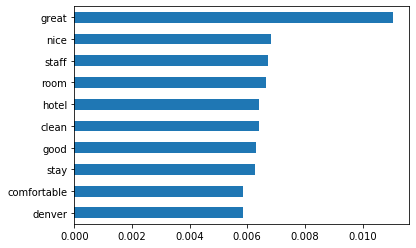

In [92]:
importances_2 = pd.Series(full_pipe.named_steps['clf'].feature_importances_, index = word_cols_2)
importances_2.sort_values().tail(10).plot(kind='barh')

In [48]:
# Grid search - fit to raw X_train since it will go through the tokenizer

# #EXAMPLE FROM LECTURE:

# ## Make a tokenizer with TweetTokenizer
# tokenizer = nltk.tokenize.RegexpTokenizer(pattern)
# vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize)
# ## Make params Grid
# #### use_idf: True/False
# #### tokenizer: None, tokenizer.tokenize
# #### criterion: gini, entropy
# #### stopwords

# params = {'text_pipe__tf_transformer__use_idf':[True, False],
#          'text_pipe__count_vectorizer__tokenizer':[None, tokenizer.tokenize],
#          'text_pipe__count_vectorizer__stop_words':[None, stopword_list],
#          'clf__criterion':['gini', 'entropy']}

# ## Make and fit grid
# grid = GridSearchCV(full_pipe,params,cv=3)
# grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        Pipeline(memory=None,
                                                 steps=[('count_vectorizer',
                                                         CountVectorizer(analyzer='word',
                                                                         binary=False,
                                                                         decode_error='ignore',
                                                                         dtype=<class 'numpy.int64'>,
                                                                         encoding='utf-8',
                                                                         input='content',
                                                                         lowercase=True,
                                                                         max_df=1.

In [49]:
# Display best params
display(grid.best_params_)

# Save best pipe (full pipe), best pipe in NOT the model
best_pipe = grid.best_estimator_

{'clf__criterion': 'gini',
 'text_pipe__count_vectorizer__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out

In [ ]:
# View best pipe
set_config(display='diagram')
best_pipe

In [ ]:
# get best model params from grid search... how to get best model out of it??, train(fit) best model, isolate best model, THEN pass into evaluate

# Evaluate model
NLP.evaluate_model(nb_classifier, X_test, y_test)

In [ ]:
# feature importance
# from NLTK

# get words NLTK
vectorizer.get_feature_names()

# get importances from model (rf in this case), set names as index
importance = pd.Series(rf.feature_importances_,index=vectorizer.get_feature_names())
importance

importance.sort_values(ascending=True).tail(20).plot(kind='barh')

In [ ]:
# get features importance
# named_steps dict of steps!!! tier through
# from a pipeline

# number features
X_train_pipe.shape

# get names
features = text_pipe.named_steps['count_vectorizer'].get_feature_names()

# preview
features[:10]

#
len(features)

### Model Iterations.....

# Topic Modeling - Unsupervised clustering per reveiw class?
